In [153]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
import math
from scipy.special import eval_legendre

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

plt.style.use('ggplot')

# Simulations based on three test functions without expansions of predictors

In [154]:

def sim_f1(X, SNR):
  """
  Test function: y = X1 + X2 - X3 - X4 
  """
  n = np.array(X).shape[0]
  p = np.array(X).shape[1]

  beta = np.zeros(p)

  for i in range(p):
      if i in [0,1]:
          beta[i] = 1
      elif i in [2,3]:
          beta[i] = -1
      else:
          beta[i] = 0

  X_ = np.copy(X)

# Accodrding to the article, We scaled each component to ensure that all components have same variance and are contributed equally to the final function. 
  for j in range(p):
    std_j = np.std(X_[:,j])
    for i in range(n):
      X_[i,j] = X_[i,j]/std_j

  y = np.random.multivariate_normal(X_.dot(beta),np.identity(n)*np.var(X_.dot(beta)/SNR))

  return y, beta

In [155]:
def sim_f2(X, SNR):
  """
  Test function: y = cos(8X1) + X2**2 + sign(X3) + |X4| + X5 + X5**2 - X5**3
  """

  n = np.array(X).shape[0]
  p = np.array(X).shape[1]
  beta = np.zeros(p)

  for i in range(p):
      if i in [0,1,2,3,4]:
          beta[i] = 1
      else:
          beta[i] = 0

  X_ = np.copy(X)

  for i in range(n):
    X_[i,0] = math.cos(8*X_[i,0])
    X_[i,1] = X_[i,1]**2
    X_[i,2] = np.sign(X_[i,2])
    X_[i,3] = abs(X_[i,3])
    X_[i,4] = X_[i,4] + X_[i,4]**2 - X_[i,4]**3

  for j in range(p):
    std_j = np.std(X_[:,j])
    for i in range(n):
      X_[i,j] = X_[i,j]/std_j

  y = np.random.multivariate_normal(X_.dot(beta),np.identity(n)*np.var(X_.dot(beta)/SNR))

  return y, beta

In [156]:
def sim_f3(X, SNR):
  """
  Test function: y = f1(X1) + f2(X2) + f3(X3); (14)
                where fj = betaj1P1(Xj) + betaj2P2(Xj) + betaj3P3(Xj), j = 1, 2, 3 that consists of the Legendre polynomials of order up to three 
                and the standardised true coefficients are: beta = (2, 1, 1/2, 1, 1, 1, -1, -4, 1)

  """
  n = np.array(X).shape[0]
  p = np.array(X).shape[1]
  beta = np.zeros(3*3+p-3)
  beta[0:9]= [2, 1, 0.5, 1, 1, 1,-1, -4, 1]
  
  X_ = np.zeros((n, 3*3+p-3))
  X_[:,9:]=X[:,3:]

  for i in range(n):
    for j in range(3):
      X_[i,3*j] = eval_legendre(1, X[i,j])
      X_[i,3*j+1] = eval_legendre(2, X[i,j])
      X_[i,3*j+2] = eval_legendre(3, X[i,j])

  for j in range(p):
    std_j = np.std(X_[:,j])
    for i in range(n):
      X_[i,j] = X_[i,j]/std_j

  y = np.random.multivariate_normal(X_.dot(beta),np.identity(n)*np.var(X_.dot(beta)/SNR))

  return y, beta

In [157]:
# for comparing the estimated betas and true betas
def plot_beta(b, b_hat, std=None):
  if len(b)==len(b_hat):
    x = range(len(b))
    plt.plot(x, b, 'k', alpha=0.5)
    plt.plot(x, b_hat, alpha=0.5)
    
  else:
    plt.subplot(121)
    plt.plot(range(len(b)), b, 'k', alpha=0.5)
    plt.subplot(122)
    plt.plot(range(len(b_hat)), b_hat, alpha=0.5)
    
  if std is not None:
        plt.fill_between(range(len(b_hat)), b_hat + std, b_hat - std, alpha=0.3)
    
  plt.show()

In [158]:
# for comparing the estimated y and true y

def plot_y(X, b_hat, y, std=None):
  
    r = range(len(y))
    y_hat = X.dot(b_hat)
    plt.plot(r, y, 'k', alpha=0.5)
    plt.plot(r, y_hat, alpha=0.5)

    if std is not None:
      plt.fill_between(r, y_hat + std, y_hat - std, alpha=0.3)

    plt.show()

In [159]:
n = 100
p = 10
SNR = 10
K = 6    # an example : setting the max degree of legendre polynomials = 6
X = np.random.uniform(low=-1, high=1, size = (n,p))
y1, beta1 = sim_f1(X,SNR)
y2, beta2 = sim_f2(X,SNR)
y3, beta3 = sim_f3(X,SNR)

# Lasso models with criterion BIC (Lasso_BIC)

In [160]:
def sk_lasso_bic(X, y, b):

    lasso_lars_ic = make_pipeline(
                          StandardScaler(), LassoLarsIC(criterion="bic", normalize=False)
                          ).fit(X, y)

    alpha_opt = lasso_lars_ic[-1].alpha_

    ls = Lasso(fit_intercept=False, alpha = alpha_opt)
    ls.fit(X, y)

    plot_beta(b, ls.coef_)
    plot_y(X, ls.coef_, y, std=None)

    y_hat = X.dot(ls.coef_)
    error = y_hat - y
    mse = sum([i ** 2 for i in error]) / len(error)

    return mse



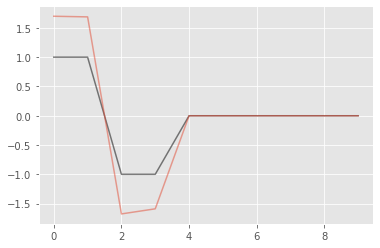

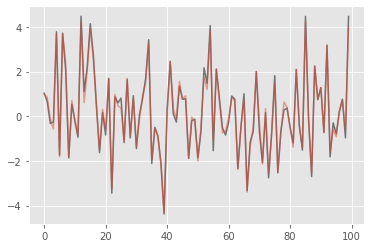

0.03836648822840444

In [161]:
sk_lasso_bic(X, y1, beta1)

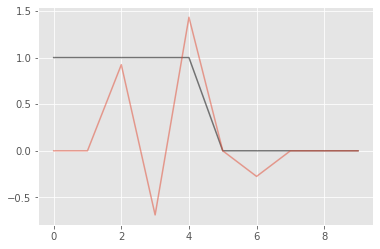

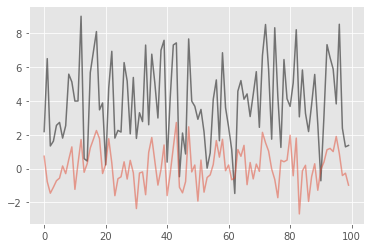

18.794716122276014

In [162]:
sk_lasso_bic(X, y2, beta2)

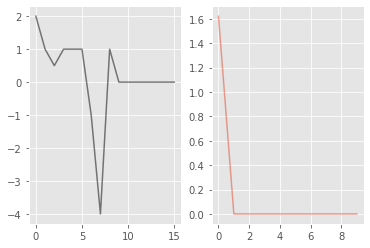

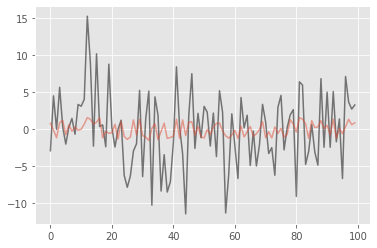

20.938615499599308

In [163]:
sk_lasso_bic(X, y3, beta3)

# Bayesian Horseshoe without expansion of Legendre for predictors (BHS_NE)

In [164]:
def pm_BHS_NE(X, y, b):
  """
  Args:
    X: original input from uniform distribution, shape: [n,p], p is 10 by default
    y: truely simulated y from test functions
    b: coefficients beta used to simulate y

  Local variables:
    delta: local shrinkage parameter
    tau: global shrinkage parameter 
  """

  BHS_NE = pm.Model()
  with BHS_NE:
      
      delta = pm.HalfCauchy('delta', 1, shape=X.shape[1])
      tau = pm.HalfCauchy('tau', 1)
      sigma = pm.InverseGamma('sigma', alpha=3, beta=1)
      beta = pm.Normal('beta', 0, sigma * sigma * tau * tau * delta * delta, shape=X.shape[1])
      y_hat = tt.dot(X, beta)
      likelihood = pm.Normal('likelihood', mu=y_hat, sigma = sigma, observed=y)
      trace = pm.sample(1000)

  b_hat = trace.get_values('beta').mean(0)
  b_sig = trace.get_values('beta').std(0)

  plot_beta(b, b_hat, std=b_sig)
  plot_y(X, b_hat, y, std=None)

  y_hat = X.dot(b_hat)
  error = y_hat - y
  mse = sum([i ** 2 for i in error]) / len(error)

  return mse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
There were 428 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6020765996143544, but should be close to 0.8. Try to increase the number of tuning steps.
There were 835 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6372353610458221, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


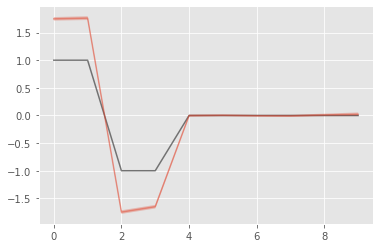

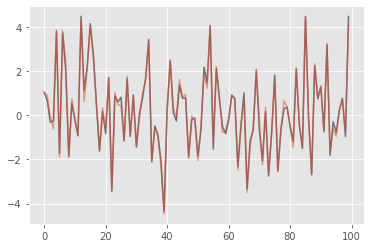

0.0337745421454512

In [165]:
pm_BHS_NE(X, y1, beta1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 715 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28944371160206434, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5142850440995761, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


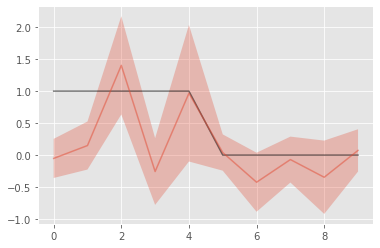

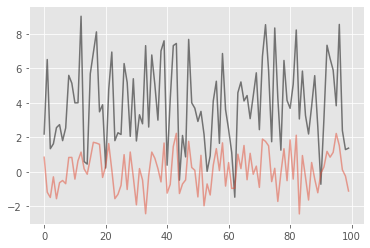

18.96148766084319

In [166]:
pm_BHS_NE(X, y2, beta2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
There were 395 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1046 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3762064942465266, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


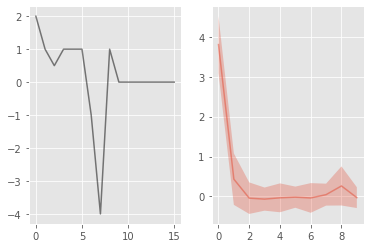

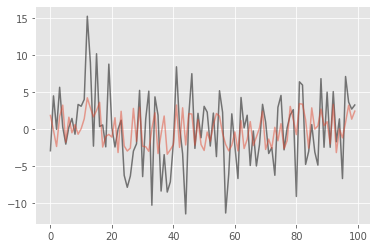

18.46091985639806

In [167]:
pm_BHS_NE(X, y3, beta3)

# Bayesian Horseshoe with expansion of Legendre for predictors (BHS)

In [168]:
def expansion_legendre (X,K):
  """
  Args:
    X: features' matrix
    K: max degree of legendre polynomials

  """
  n = np.array(X).shape[0]
  p = np.array(X).shape[1]
  X_E = np.zeros((n,K*p))

  for i in range(n):
    for j in range(p):
      for m in range(K): 
       X_E[i,K*j+m] = eval_legendre(m+1, X[i,j])

  return X_E

In [169]:
def pm_BHS(X,K, y, b):
  """
  Add expansion of Legendre on X, the rest is the same as the function pm_BHS_NE.

  Args:
    X: original input from uniform distribution, shape: [n,p], p is 10 by default
    K: the max degree of Legendre polynomial to expand X, thus expanded input X_E is of shape [n, K*p]
    y: truely simulated y from test functions
    b: coefficients beta used to simulate y

  Local variables:
    X_E: the expansion of Legendre of predictors
    delta: local shrinkage parameter
    tau: global shrinkage parameter 
  """

  X_E = expansion_legendre(X,K)
  BHS = pm.Model()

  with BHS:
      
      delta = pm.HalfCauchy('delta', 1, shape=X_E.shape[1])
      tau = pm.HalfCauchy('tau', 1)
      sigma = pm.InverseGamma('sigma', alpha=3, beta=1)
      beta = pm.Normal('beta', 0, sigma * sigma * tau * tau * delta * delta, shape=X_E.shape[1])
      y_hat = tt.dot(X_E, beta)
      likelihood = pm.Normal('likelihood', mu=y_hat, sigma = sigma, observed=y)
      trace = pm.sample(1000)

  b_hat = trace.get_values('beta').mean(0)
  b_sig = trace.get_values('beta').std(0)

  plot_beta(b, b_hat, std=b_sig)
  plot_y(X_E, b_hat, y, std=None)
  
  y_hat = X_E.dot(b_hat)
  error = y_hat - y
  mse = sum([i ** 2 for i in error]) / len(error)

  return mse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 180 seconds.
There were 902 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6966803133711881, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1771 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7058504971449995, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


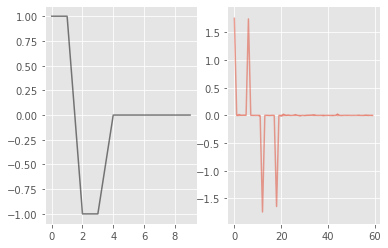

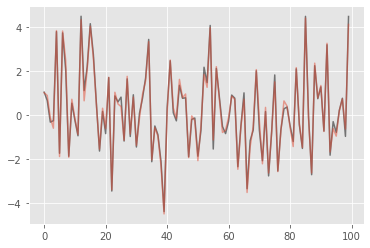

0.03306003869354026

In [170]:
pm_BHS(X,K, y1, beta1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 139 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.013529923846824866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1962 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44644340355792966, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


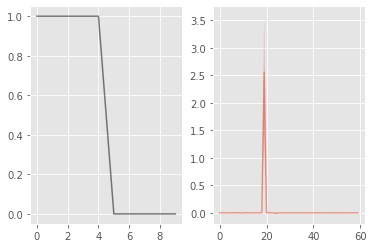

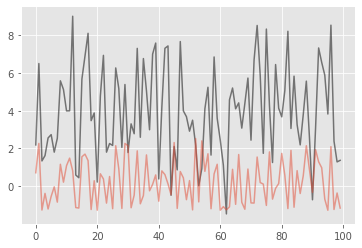

18.98569436588927

In [171]:
pm_BHS(X,K, y2, beta2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma, tau, delta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 208 seconds.
There were 814 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1577 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


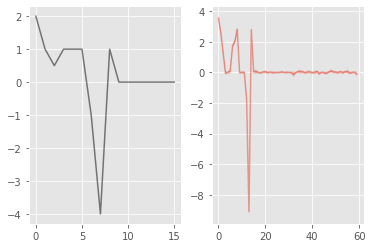

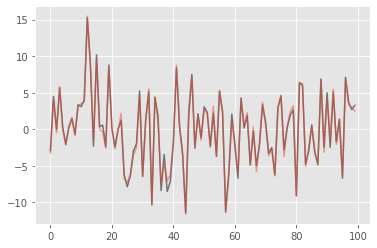

0.23855670641707913

In [172]:
pm_BHS(X,K, y3, beta3)

# Grouped horseshoe (BHSG)

In [173]:
theano.configdefaults.config.compute_test_value = "ignore"

In [174]:
def pm_BHSG(X,K, y, b):
  """
  Args:
    X: original input from uniform distribution, shape: [n,p], p is 10 by default
    K: the max degree of Legendre polynomial to expand X, thus expanded input X_E is of shape [n, K*p]
    y: truely simulated y from test functions
    b: coefficients beta used to simulate y

  local variables:
    X_E: the expansion of Legendre of predictors
    num: number of groups in X_E 
    tot: total number of features in X_E, is K*p defined in function expansion_legendre
  """

  X_E = expansion_legendre(X,K)


  p = np.array(X).shape[1]
  BHSG = pm.Model()

  num = p
  tot = X_E.shape[1]

  with BHSG:

      
      #------------ here defines the lam: shrinkage parameters for group variables ------------------------------
      lam = pm.HalfCauchy('lam', 1, shape=int(num))
      lam_= tt.ones(int(tot/num))*lam[0]
      for i in range(int(num)-1):
        lam_ = tt.concatenate([lam_, tt.ones(int(tot/num))*lam[i+1]])
      #----------------------------------------------------------------------------------------------------------

      sigma = pm.InverseGamma('sigma', alpha=3, beta=1)
      tau = pm.HalfCauchy('tau', 1)      
      beta = pm.Normal('beta', 0, sigma * sigma * tau * tau * lam_ * lam_, shape=X_E.shape[1])
      y_hat = tt.dot(X_E, beta)
      likelihood = pm.Normal('likelihood', mu=y_hat, sigma = sigma, observed=y)
      trace = pm.sample(1000)

  b_hat = trace.get_values('beta').mean(0)
  b_sig = trace.get_values('beta').std(0)

  plot_beta(b, b_hat, std=b_sig)
  plot_y(X_E, b_hat, y, std=None)
  
  y_hat = X_E.dot(b_hat)
  error = y_hat - y
  mse = sum([i ** 2 for i in error]) / len(error)

  return mse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 127 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


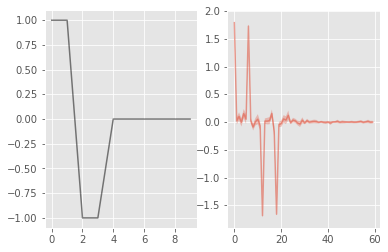

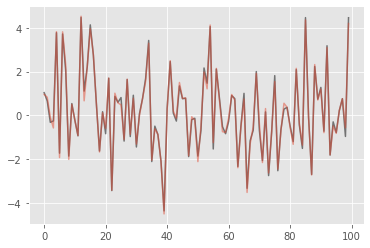

0.021730271378064502

In [175]:
pm_BHSG(X,K,y1,beta1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 132 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


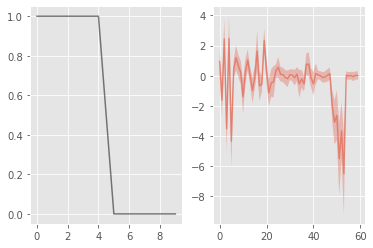

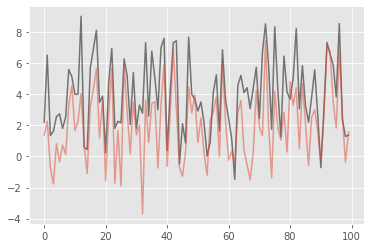

6.031561035042059

In [176]:
pm_BHSG(X,K,y2,beta2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 117 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7149918104490474, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


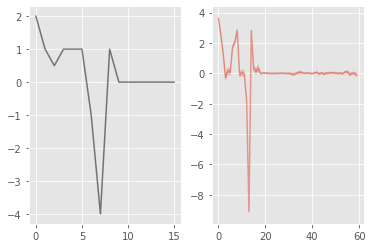

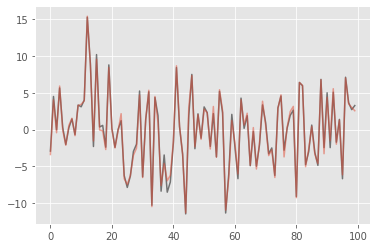

0.22554664715791706

In [177]:
pm_BHSG(X,K,y3,beta3)

# Hierarchical grouped horseshoe (HBHSG)

In [178]:
def pm_HBHSG(X,K, y, b):
  """
  Args:
    X: original input from uniform distribution, shape: [n,p], p is 10 by default
    K: the max degree of Legendre polynomial to expand X, thus expanded input X_E is of shape [n, K*p]
    y: truely simulated y from test functions
    b: coefficients beta used to simulate y

  local variables:
    X_E: the expansion of Legendre of predictors
    num: number of groups in X_E 
    tot: total number of features in X_E, is K*p defined in function expansion_legendre
  """

  X_E = expansion_legendre(X,K)


  p = np.array(X).shape[1]
  HBHSG = pm.Model()

  num = p/2
  tot = X_E.shape[1]

  with HBHSG:

      
      #----------------------- here defines the lam: shrinkage parameters for group variables ------------------------------
      lam = pm.HalfCauchy('lam', 1, shape=int(num))
      lam_= tt.ones(int(tot/num))*lam[0]
      for i in range(int(num)-1):
        lam_ = tt.concatenate([lam_, tt.ones(int(tot/num))*lam[i+1]])
      #---------------------------------------------------------------------------------------------------------------------


      #----------------------- here defines delta: shrinkage parameters for each predictor variable ----------------------
      delta = pm.HalfCauchy('delta', 1, shape=p)
      delta_= tt.ones(K)*delta[0]
      for i in range(p-1):
        delta_ = tt.concatenate([delta_, tt.ones(K)*delta[i+1]])
      #---------------------------------------------------------------------------------------------------------------------


      sigma = pm.InverseGamma('sigma', alpha=3, beta=1)
      tau = pm.HalfCauchy('tau', 1)      
      beta = pm.Normal('beta', 0, sigma * sigma * tau * tau * lam_ * lam_ * delta_ * delta_, shape=X_E.shape[1])
      y_hat = tt.dot(X_E, beta)
      likelihood = pm.Normal('likelihood', mu=y_hat, sigma = sigma, observed=y)
      trace = pm.sample(1000)

  b_hat = trace.get_values('beta').mean(0)
  b_sig = trace.get_values('beta').std(0)

  plot_beta(b, b_hat, std=b_sig)
  plot_y(X_E, b_hat, y, std=None)
  
  y_hat = X_E.dot(b_hat)
  error = y_hat - y
  mse = sum([i ** 2 for i in error]) / len(error)

  return mse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, delta, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 395 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6754377963955526, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


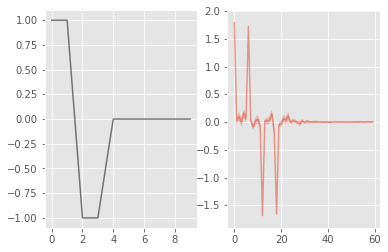

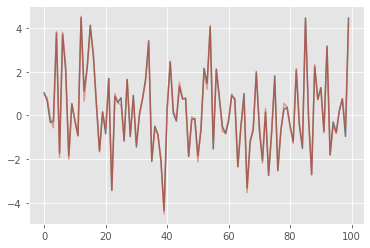

0.023526314895755775

In [179]:
pm_HBHSG(X,K, y1, beta1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, delta, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 225 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7090782783686429, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


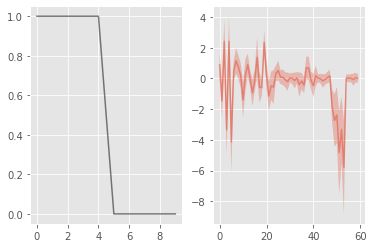

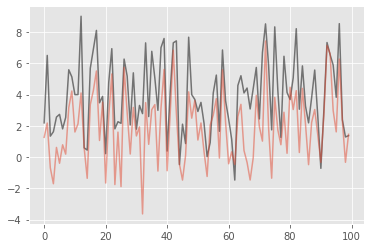

6.46922628354067

In [180]:
pm_HBHSG(X,K, y2, beta2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, tau, sigma, delta, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 269 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6570283719888582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


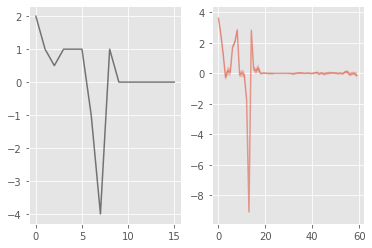

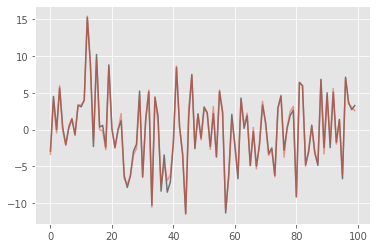

0.2341052091411589

In [181]:
pm_HBHSG(X,K, y3, beta3)